# Calculate some cross-correlations in time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from scipy.signal import correlate

In [46]:
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/'
figures_out_path = os.path.join(data_path, 'figures')

# Load velocity
v_fn = os.path.join(data_path, 'velocity', 'hubbard_inversion_2015-10-01_2023-01-01_xform.nc')
v = xr.open_dataset(v_fn)
v = v.rio.write_crs('EPSG:3413')
v = v.rio.reproject('EPSG:3338') # reproject to Alaska Albers
v['v'] = np.sqrt(v['vx']**2 + v['vy']**2) 
# Convert units from m/yr to m/d
v = v / 365

# Load terminus
term_fn = os.path.join(data_path, 'terminus', 'terminus_position_smooth.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.set_index('Date', inplace=True)
# add mean column
term['mean'] = term.mean(axis=1)

# Load weather data
weather_fn = os.path.join(data_path, 'weather', 'compiled_weather_data_PDDs.csv')
weather = pd.read_csv(weather_fn)
weather.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
weather['Date'] = pd.to_datetime(weather['Date'])
weather.set_index('Date', inplace=True)

## Sample upglacier and downglacier velocities

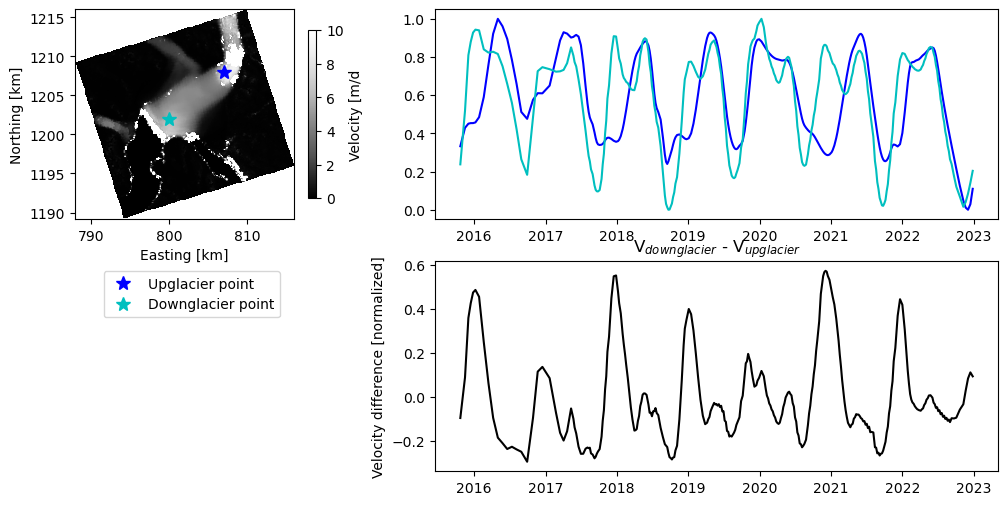

In [69]:
# Pick a couple points
p1 = [807e3, 1208e3]
p2 = [800e3, 1202e3]

# Calculate the mean at each point over time
v1 = v.sel(x=p1[0], y=p1[1], method='nearest')
v1 = xr.where(v1 > 15, np.nan, v1)
v2 = v.sel(x=p2[0], y=p2[1], method='nearest')
v2 = xr.where(v2 > 15, np.nan, v2)

# Normalize from 0 to 1
v1_norm =  (v1 - np.min(v1)) / (np.max(v1) - np.min(v1))
v2_norm =  (v2 - np.min(v2)) / (np.max(v2) - np.min(v2))

# Plot
fig, ax = plt.subplots(2, 2, figsize=(12,6), gridspec_kw={'width_ratios': [1, 2]})
ax = ax.flatten()
      
v_im = ax[0].imshow(v.mean(dim='time').v.data, cmap='Greys_r', clim=(0,10),
                    extent=(np.min(v.x.data)/1e3, np.max(v.x.data)/1e3, 
                            np.min(v.y.data)/1e3, np.max(v.y.data)/1e3))
ax[0].plot(p1[0]/1e3, p1[1]/1e3, '*b', markersize=10, label='Upglacier point')
ax[0].plot(p2[0]/1e3, p2[1]/1e3, '*c', markersize=10, label='Downglacier point')
ax[0].legend(loc='lower left', bbox_to_anchor=[0.1, -0.5, 0.2, 0.2])
fig.colorbar(v_im, ax=ax[0], shrink=0.8, label='Velocity [m/d')
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[1].plot(v1.time.data, v1_norm.v.data, '-b')
ax[1].plot(v2.time.data, v2_norm.v.data, '-c')
ax[2].remove()
ax[3].plot(v1.time.data, v2_norm.v.data - v1_norm.v.data, '-k')
ax[3].set_title('V$_{downglacier}$ - V$_{upglacier}$')
ax[3].set_ylabel('Velocity difference [normalized]')

plt.show()

### Velocity-Terminus X-corr

In [ ]:
# Set up figure
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1.5,1]}, figsize=(14, 20))
ax = ax.flatten()

# Resample terminus positions at equal time spacing
term_resamp = term.resample('2W').median()
t = np.array(term_resamp.index)
# Iterate over terminus sections
for i, geom in enumerate(term_sections.geometry[0:-1]):
    # clip v to terminus section
    v_clip = v.rio.clip([geom], term_sections.crs)
    # calculate median velocity in terminus section
    v_clip_median = v_clip.median(dim=['x', 'y']).v.data
    # resample velocity in time
    v_clip_median_resamp = np.interp(t.astype(float), v.time.data.astype(float), v_clip_median)
    # de-mean
    v_clip_median_resamp_demean = v_clip_median_resamp - np.nanmean(v_clip_median_resamp)
    term_values = -1 * (term_resamp[term_resamp.columns[i]] - np.nanmean(term_resamp[term_resamp.columns[i]]))
    # plot time series
    ax[i*2].plot(t, v_clip_median_resamp, '-b')
    ax[i*2].set_title(term_resamp.columns[i].replace(' [m]', ''))
    ax[i*2].set_ylabel('Velocity, de-meaned [m/y]', color='b')
    ax[i*2].spines.left.set_color('b')
    ax[i*2].tick_params(axis='y', colors='b')
    ax2 = ax[i*2].twinx()
    ax2.plot(t, term_values, '-m')
    ax2.set_ylabel('Terminus retreat, de-meaned [m]', color='m')
    ax2.spines.right.set_color('m')
    ax2.tick_params(axis='y', colors='m')    
    # calculate cross-correlation for each year
    years = np.unique(t.astype('datetime64[Y]').astype(int) + 1970)
    for j, year in enumerate(years):
        # subset time series to year
        df = pd.DataFrame(term_values.loc[term_values.index.year == year])
        t_v = t.astype('datetime64[Y]').astype(int) + 1970
        Ivyear = np.ravel(np.argwhere(t_v == year))
        df['v'] = v_clip_median_resamp_demean[Ivyear]
        df.dropna(inplace=True)
        # calculate Xcorr(v, term)
        xcorr = correlate(df.values[:,1], df.values[:,0], mode='full', method='auto')
        t_xcorr = (np.arange(0,len(xcorr)) * 2)
        t_xcorr = t_xcorr - np.mean(t_xcorr)
        # plot X-corr
        color = plt.cm.viridis(j/(len(years)-1))
        ax[i*2+1].plot(t_xcorr, xcorr, '-', color=color, label=str(year))
        ax[i*2+1].set_xlabel('Weeks')
        ax[i*2+1].set_ylabel('X-corr')
        ax[i*2+1].legend(loc='lower left', bbox_to_anchor=[1.0, 0.2, 0.2, 0.2])
fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'xcorr_velocity_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

### Velocity-Weather X-corr

In [ ]:
# define columns to use
columns = ['PDD_Haenke1', 'Precip_Yakutat']
column_names = ['PDD', 'precipitation']

# resample at weekly intervals
weather = weather.resample('1W').mean()
t = np.array(weather.index)

# Iterate over weather columns
for column, column_name in zip(columns, column_names):
    # Set up figure
    plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
    fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1.5,1]}, figsize=(16, 20))
    ax = ax.flatten()

    # subset weather df to column
    weather_column = weather[column]
    # Iterate over terminus sections
    for i, geom in enumerate(term_sections.geometry[0:-1]):
        # clip v to terminus section
        v_clip = v.rio.clip([geom], term_sections.crs)
        # calculate median velocity in terminus section
        v_clip_median = v_clip.median(dim=['x', 'y']).v.data
        # resample velocity in time
        v_clip_median_resamp = np.interp(t.astype(float), v.time.data.astype(float), v_clip_median)
        # de-mean
        v_clip_median_resamp_demean = v_clip_median_resamp - np.nanmean(v_clip_median_resamp)
        weather_column = weather_column - np.nanmean(weather_column)
        # plot time series
        ax[i*2].plot(t, v_clip_median_resamp, '-b')
        ax[i*2].set_title(term_sections.section[i])
        ax[i*2].set_ylabel('Velocity, de-meaned [m/y]', color='b')
        ax[i*2].spines.left.set_color('b')
        ax[i*2].tick_params(axis='y', colors='b')
        ax[i*2].set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
        ax2 = ax[i*2].twinx()
        ax2.plot(t, weather_column.values, '-c')
        ax2.set_ylabel(column_name + ', de-meaned', color='c')
        ax2.spines.right.set_color('c')
        ax2.tick_params(axis='y', colors='c')    
        # calculate cross-correlation for each year
        years = np.arange(2016, 2023)
        for j, year in enumerate(years):
            # subset time series to year
            df = pd.DataFrame(weather_column.loc[weather_column.index.year == year])
            Ivyear = np.ravel(np.argwhere(t.astype('datetime64[Y]').astype(int) + 1970 == year))
            df['v'] = v_clip_median_resamp_demean[Ivyear]
            df.dropna(inplace=True)
            # calculate Xcorr(v, term)
            xcorr = correlate(df.values[:,1], df.values[:,0], mode='full', method='auto')
            t_xcorr = (np.arange(0,len(xcorr)) * 2)
            t_xcorr = t_xcorr - np.mean(t_xcorr)
            # plot X-corr
            color = plt.cm.viridis(j/(len(years)-1))
            ax[i*2+1].plot(t_xcorr, xcorr, '-', color=color, label=str(year))
            ax[i*2+1].set_xlabel('Weeks')
            ax[i*2+1].set_ylabel('X-corr')
            ax[i*2+1].legend(loc='lower left', bbox_to_anchor=[1.0, 0.0, 0.2, 0.2])
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    plt.show()
    
    # save figure
    fig_fn = os.path.join(figures_out_path, 'xcorr_velocity_' + column_name + '.png')
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('Figure saved to file:', fig_fn)

## Comparing upper and lower glacier

In [ ]:
# Define velocity clip segments

plt.imshow(v.isel(time=0).v.data, clim=(0,2500),
           extent=(np.min(v.x.data), np.max(v.x.data),
                   np.min(v.y.data), np.max(v.y.data)))